# Capstone Project - The Battle of the Neighborhoods (Week 2)
### IBM Data Science Profession Certificate -  Capstone
#### Vegan Restaurants in Greater Vancouver Area

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

Restaurants business is a profitable but a tricky business. There are variety of options in restaurants. However, there is one growing category of restaurants all over the world. Vegetarian / Vegan category of restaurants are not tied to a specific cuisine. There is growing number of people opting for this type of food as they are both healthy & environmentally conscious. Here in Vancouver BC, vegan option of food is very famous. It helps giving options to people who have allergies to enjoy a safe healthy food. It is not just limited to people with allergies, anyone can opt for this kind of food. It provided quite a large variety of healthy options as well. The main question we are trying to find answers for, is there enough market for more vegan restaurants in the Greater Vancouver area.

Here are the major cities covered in the Greater Vancouver area:
+	Vancouver
+	Richmond
+	Burnaby
+	Surrey
+	Langley
+	South Surrey/White Rock


## Data <a name="data"></a>

Following factors that will influence our decision are:
+	number of existing restaurants in each of the city (any type of restaurant)
+	Comparison of Non-vegan restaurants to Vegan ones
+	Restaurants data and location in every city will be obtained using Foursquare API

**One important assumption:** I have not considered existing restaurants which also serve vegan options. I am looking for pure vegan restaurant. My data is heavily dependent on the foursquare data and it is assumed it is accurate.


In [233]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
import folium # map rendering library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
from sklearn.preprocessing import MinMaxScaler

In [234]:
address = ['Vancouver', 'South Surrey', 'White Rock', 'Surrey', 'Burnaby', 'Richmond', 'Langley']
province = 'British Columbia'
df_BC_City = pd.DataFrame(columns=['City', 'Latitude', 'Longitude'])
i = 0
for all in address:
    find_lat_long = all , province
    geolocator = Nominatim(user_agent="BC_explorer")
    location = geolocator.geocode(find_lat_long)
    latitude = location.latitude
    longitude = location.longitude
    df_BC_City.loc[i, 'City'] = all
    df_BC_City.loc[i, 'Latitude'] = latitude
    df_BC_City.loc[i, 'Longitude'] = longitude
    i = i + 1
df_BC_City

,City,Latitude,Longitude
0,Vancouver,49.2609,-123.114
1,South Surrey,49.0568,-122.817
2,White Rock,49.0235,-122.798
3,Surrey,49.1913,-122.849
4,Burnaby,49.2434,-122.973
5,Richmond,49.1632,-123.137
6,Langley,49.1065,-122.55


In [235]:
CLIENT_ID = '5MG2XUM2YZXTCLG3MXCPVDB4BVGNNE5413AFDU54MRCY4SJD' # your Foursquare ID
CLIENT_SECRET = 'CZXPK4ILKGKBFBJTK1BXBWPC5IQCKACW11U4ZVVY34WBSZMY' # your Foursquare Secret
VERSION = '20200810' # Foursquare API version

In [236]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    LIMIT = 100
    venues_list=[]
    name = names
    lat = latitudes 
    lng = longitudes 
    
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        #  4d4b7105d754a06374d81259  50aa9e744b90af0d42d5de0e 4bf58dd8d48988d1d3941735
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng,
        radius, 
        LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [237]:
BC_venues = getNearbyVenues(names=df_BC_City['City'], latitudes=df_BC_City['Latitude'], longitudes=df_BC_City['Longitude'])
BC_venues = BC_venues[BC_venues['Venue Category'] != ('Vegetarian / Vegan Restaurant')]
BC_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vancouver,49.260872,-123.113953,La Taqueria Pinche Taco Shop,49.263534,-123.112795,Taco Place
1,Vancouver,49.260872,-123.113953,Vij's,49.257525,-123.115083,Indian Restaurant
2,Vancouver,49.260872,-123.113953,Indian Roti Kitchen,49.258950,-123.115087,Indian Restaurant
3,Vancouver,49.260872,-123.113953,Lemonade Gluten Free Bakery,49.255158,-123.115276,Bakery
4,Vancouver,49.260872,-123.113953,Corduroy Pie Company,49.257053,-123.121265,Pizza Place
...,...,...,...,...,...,...,...
550,Langley,49.106472,-122.550131,Ta Ke Sushi,49.091170,-122.607207,Japanese Restaurant
551,Langley,49.106472,-122.550131,Panago Pizza,49.091067,-122.607550,Pizza Place
552,Langley,49.106472,-122.550131,Quiznos,49.090230,-122.607116,Sandwich Place
553,Langley,49.106472,-122.550131,Industrial Park Sandwich Works,49.102037,-122.486466,Sandwich Place


In [238]:
BC_venues_df = BC_venues.groupby('City').count()
BC_venues_df = BC_venues_df[['Venue Category']]
BC_venues_df = BC_venues_df.rename(columns={'Venue Category':'Total Non-Vegan Restaurants'})
BC_venues_df.reset_index()

,City,Total Non-Vegan Restaurants
0,Burnaby,63
1,Langley,14
2,Richmond,99
3,South Surrey,89
4,Surrey,100
5,Vancouver,97
6,White Rock,89


In [239]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        #  4d4b7105d754a06374d81259  50aa9e744b90af0d42d5de0e 4bf58dd8d48988d1d3941735
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d1d3941735'.format(
            
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [240]:
BC_Venues_Vegan = getNearbyVenues(names=df_BC_City['City'],
                                   latitudes=df_BC_City['Latitude'],
                                   longitudes=df_BC_City['Longitude']
                                  )

Vancouver
South Surrey
White Rock
Surrey
Burnaby
Richmond
Langley


In [241]:
BC_Venues_Vegan = getNearbyVenues(names=df_BC_City['City'], latitudes=df_BC_City['Latitude'], longitudes=df_BC_City['Longitude'])
BC_Venues_Vegan = BC_Venues_Vegan[BC_Venues_Vegan['Venue Category'] == ('Vegetarian / Vegan Restaurant')]
BC_Venues_Vegan

Vancouver
South Surrey
White Rock
Surrey
Burnaby
Richmond
Langley


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vancouver,49.260872,-123.113953,The Acorn,49.249442,-123.101105,Vegetarian / Vegan Restaurant
1,Vancouver,49.260872,-123.113953,The Juice Truck,49.266447,-123.105531,Vegetarian / Vegan Restaurant
2,Vancouver,49.260872,-123.113953,Budgie’s Burritos,49.263714,-123.100292,Vegetarian / Vegan Restaurant
3,Vancouver,49.260872,-123.113953,Meet on Main,49.246747,-123.101096,Vegetarian / Vegan Restaurant
4,Vancouver,49.260872,-123.113953,Loving Hut Express,49.273904,-123.121643,Vegetarian / Vegan Restaurant
...,...,...,...,...,...,...,...
69,Burnaby,49.243380,-122.972546,Vega / Sequel Naturals,49.256679,-122.994747,Vegetarian / Vegan Restaurant
70,Burnaby,49.243380,-122.972546,Dharma Garden Veggie Deli,49.235218,-123.037877,Vegetarian / Vegan Restaurant
71,Richmond,49.163168,-123.137414,4 Stones Vegetarian Cuisine,49.170412,-123.139635,Vegetarian / Vegan Restaurant
72,Richmond,49.163168,-123.137414,Taste of Zen,49.133083,-123.123413,Vegetarian / Vegan Restaurant


In [242]:
BC_Venues_Vegan.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vancouver,49.260872,-123.113953,The Acorn,49.249442,-123.101105,Vegetarian / Vegan Restaurant
1,Vancouver,49.260872,-123.113953,The Juice Truck,49.266447,-123.105531,Vegetarian / Vegan Restaurant
2,Vancouver,49.260872,-123.113953,Budgie’s Burritos,49.263714,-123.100292,Vegetarian / Vegan Restaurant
3,Vancouver,49.260872,-123.113953,Meet on Main,49.246747,-123.101096,Vegetarian / Vegan Restaurant
4,Vancouver,49.260872,-123.113953,Loving Hut Express,49.273904,-123.121643,Vegetarian / Vegan Restaurant


In [243]:
BC_Venues_Vegan.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Burnaby,2,2,2,2,2,2
Richmond,3,3,3,3,3,3
South Surrey,2,2,2,2,2,2
Surrey,3,3,3,3,3,3
Vancouver,50,50,50,50,50,50
White Rock,2,2,2,2,2,2


## Methodology <a name="methodology"></a>


Find out the restaurants data in each of the city, try radius of 5 KMs as Greater Vancouver area is tightly knitted to each other with a small radius. So we will be able to find get most of the restaurants data within each of the city. Filter the data to get Non-vegan restaurants compare that with Vegan Restaurants. It should help us understand how much of vegan restaurants has share in the total number of restaurants. Plot graph to show the comparison 

In [244]:
# one hot encoding
BC_onehot = pd.get_dummies(BC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BC_onehot['City'] = BC_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [BC_onehot.columns[-1]] + list(BC_onehot.columns[:-1])
BC_onehot = BC_onehot[fixed_columns]

BC_onehot

,City,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,...,Seafood Restaurant,Shanghai Restaurant,Snack Place,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Vancouver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Vancouver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Vancouver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Vancouver,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Vancouver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,Langley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
551,Langley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
552,Langley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
553,Langley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
BC_onehot.shape

(551, 59)

In [246]:
BC_grouped = BC_onehot.groupby('City').mean().reset_index()
BC_grouped

,City,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,...,Seafood Restaurant,Shanghai Restaurant,Snack Place,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Burnaby,0.015873,0.015873,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.015873,...,0.000000,0.031746,0.015873,0.000000,0.111111,0.000000,0.015873,0.000000,0.000000,0.031746
1,Langley,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,...,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000
2,Richmond,0.030303,0.040404,0.010101,0.000000,0.020202,0.000000,0.000000,0.020202,0.020202,...,0.010101,0.000000,0.010101,0.010101,0.070707,0.010101,0.010101,0.000000,0.000000,0.070707
3,South Surrey,0.056180,0.000000,0.000000,0.000000,0.056180,0.000000,0.011236,0.033708,0.033708,...,0.022472,0.000000,0.000000,0.011236,0.067416,0.000000,0.000000,0.022472,0.011236,0.000000
4,Surrey,0.030000,0.010000,0.010000,0.000000,0.010000,0.000000,0.000000,0.010000,0.060000,...,0.000000,0.000000,0.000000,0.000000,0.110000,0.020000,0.000000,0.000000,0.030000,0.040000
5,Vancouver,0.010309,0.020619,0.010309,0.020619,0.123711,0.010309,0.000000,0.030928,0.010309,...,0.082474,0.000000,0.000000,0.010309,0.051546,0.041237,0.000000,0.000000,0.020619,0.030928
6,White Rock,0.078652,0.000000,0.000000,0.000000,0.044944,0.000000,0.011236,0.033708,0.033708,...,0.033708,0.000000,0.000000,0.022472,0.056180,0.011236,0.000000,0.022472,0.022472,0.000000


In [247]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [248]:
num_top_venues = 11

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = BC_grouped['City']

for ind in np.arange(BC_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BC_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue
0,Burnaby,Sushi Restaurant,Japanese Restaurant,Pizza Place,Bakery,Café,Chinese Restaurant,Italian Restaurant,Sandwich Place,Korean Restaurant,Vietnamese Restaurant,Fast Food Restaurant
1,Langley,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Café,Asian Restaurant,BBQ Joint,Falafel Restaurant,Sushi Restaurant,Pizza Place,Diner,Burger Joint
2,Richmond,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,Food Court,Sushi Restaurant,Restaurant,Asian Restaurant,Korean Restaurant,Fried Chicken Joint,Malay Restaurant,American Restaurant
3,South Surrey,Café,Fast Food Restaurant,Japanese Restaurant,Pizza Place,Sushi Restaurant,Restaurant,American Restaurant,Bakery,Sandwich Place,Deli / Bodega,Fish & Chips Shop
4,Surrey,Sushi Restaurant,Fast Food Restaurant,Sandwich Place,Burger Joint,Indian Restaurant,Restaurant,Pizza Place,Vietnamese Restaurant,Chinese Restaurant,Gastropub,Greek Restaurant


In [249]:
# set number of clusters
kclusters = 3

BC_grouped_clustering = BC_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:200] 

array([0, 1, 0, 2, 0, 2, 2])

In [250]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

BC_merged = BC_venues

city_venues_sorted

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
BC_merged = BC_merged.join(city_venues_sorted.set_index('City'), on='City')

BC_merged # check the last columns!

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue
0,Vancouver,49.260872,-123.113953,La Taqueria Pinche Taco Shop,49.263534,-123.112795,Taco Place,2,Bakery,Café,Seafood Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Taco Place,Vietnamese Restaurant,Sandwich Place,Breakfast Spot
1,Vancouver,49.260872,-123.113953,Vij's,49.257525,-123.115083,Indian Restaurant,2,Bakery,Café,Seafood Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Taco Place,Vietnamese Restaurant,Sandwich Place,Breakfast Spot
2,Vancouver,49.260872,-123.113953,Indian Roti Kitchen,49.258950,-123.115087,Indian Restaurant,2,Bakery,Café,Seafood Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Taco Place,Vietnamese Restaurant,Sandwich Place,Breakfast Spot
3,Vancouver,49.260872,-123.113953,Lemonade Gluten Free Bakery,49.255158,-123.115276,Bakery,2,Bakery,Café,Seafood Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Taco Place,Vietnamese Restaurant,Sandwich Place,Breakfast Spot
4,Vancouver,49.260872,-123.113953,Corduroy Pie Company,49.257053,-123.121265,Pizza Place,2,Bakery,Café,Seafood Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Taco Place,Vietnamese Restaurant,Sandwich Place,Breakfast Spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,Langley,49.106472,-122.550131,Ta Ke Sushi,49.091170,-122.607207,Japanese Restaurant,1,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Café,Asian Restaurant,BBQ Joint,Falafel Restaurant,Sushi Restaurant,Pizza Place,Diner,Burger Joint
551,Langley,49.106472,-122.550131,Panago Pizza,49.091067,-122.607550,Pizza Place,1,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Café,Asian Restaurant,BBQ Joint,Falafel Restaurant,Sushi Restaurant,Pizza Place,Diner,Burger Joint
552,Langley,49.106472,-122.550131,Quiznos,49.090230,-122.607116,Sandwich Place,1,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Café,Asian Restaurant,BBQ Joint,Falafel Restaurant,Sushi Restaurant,Pizza Place,Diner,Burger Joint
553,Langley,49.106472,-122.550131,Industrial Park Sandwich Works,49.102037,-122.486466,Sandwich Place,1,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Café,Asian Restaurant,BBQ Joint,Falafel Restaurant,Sushi Restaurant,Pizza Place,Diner,Burger Joint


In [251]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BC_merged['Venue Latitude'], BC_merged['Venue Longitude'], BC_merged['City'], BC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [252]:
# one hot encoding
BC_onehot_vegan = pd.get_dummies(BC_Venues_Vegan[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BC_onehot_vegan['City'] = BC_Venues_Vegan['City'] 

# move neighborhood column to the first column
fixed_columns = [BC_onehot_vegan.columns[-1]] + list(BC_onehot_vegan.columns[:-1])
BC_onehot_vegan = BC_onehot_vegan[fixed_columns]

BC_onehot_vegan

,City,Vegetarian / Vegan Restaurant
0,Vancouver,1
1,Vancouver,1
2,Vancouver,1
3,Vancouver,1
4,Vancouver,1
...,...,...
69,Burnaby,1
70,Burnaby,1
71,Richmond,1
72,Richmond,1


In [253]:
BC_onehot_vegan.shape

(62, 2)

In [254]:
BC_grouped_vegan = BC_onehot_vegan.groupby('City').mean().reset_index()
BC_grouped_vegan

,City,Vegetarian / Vegan Restaurant
0,Burnaby,1
1,Richmond,1
2,South Surrey,1
3,Surrey,1
4,Vancouver,1
5,White Rock,1


In [255]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [256]:
num_top_venues = 1

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted_vegan = pd.DataFrame(columns=columns)
city_venues_sorted_vegan['City'] = BC_grouped_vegan['City']

#for ind in np.arange(BC_grouped.shape[0]):
 #   city_venues_sorted_vegan.iloc[ind, :0] = return_most_common_venues(BC_grouped_vegan.iloc[ind, :0], num_top_venues)

city_venues_sorted_vegan.head()

,City,1st Most Common Venue
0,Burnaby,NaN
1,Richmond,NaN
2,South Surrey,NaN
3,Surrey,NaN
4,Vancouver,NaN


In [257]:
# set number of clusters
kclusters = 1

BC_grouped_clustering_vegan = BC_grouped_vegan.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BC_grouped_clustering_vegan)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([0, 0, 0, 0, 0])

In [258]:
# add clustering labels
city_venues_sorted_vegan.insert(0, 'Cluster Labels', kmeans.labels_)

BC_merged_vegan = BC_Venues_Vegan

city_venues_sorted_vegan

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
BC_merged_vegan = BC_merged_vegan.join(city_venues_sorted_vegan.set_index('City'), on='City')

BC_merged_vegan = BC_merged_vegan.drop(columns = ['1st Most Common Venue'])
BC_merged_vegan

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Vancouver,49.260872,-123.113953,The Acorn,49.249442,-123.101105,Vegetarian / Vegan Restaurant,0
1,Vancouver,49.260872,-123.113953,The Juice Truck,49.266447,-123.105531,Vegetarian / Vegan Restaurant,0
2,Vancouver,49.260872,-123.113953,Budgie’s Burritos,49.263714,-123.100292,Vegetarian / Vegan Restaurant,0
3,Vancouver,49.260872,-123.113953,Meet on Main,49.246747,-123.101096,Vegetarian / Vegan Restaurant,0
4,Vancouver,49.260872,-123.113953,Loving Hut Express,49.273904,-123.121643,Vegetarian / Vegan Restaurant,0
...,...,...,...,...,...,...,...,...
69,Burnaby,49.243380,-122.972546,Vega / Sequel Naturals,49.256679,-122.994747,Vegetarian / Vegan Restaurant,0
70,Burnaby,49.243380,-122.972546,Dharma Garden Veggie Deli,49.235218,-123.037877,Vegetarian / Vegan Restaurant,0
71,Richmond,49.163168,-123.137414,4 Stones Vegetarian Cuisine,49.170412,-123.139635,Vegetarian / Vegan Restaurant,0
72,Richmond,49.163168,-123.137414,Taste of Zen,49.133083,-123.123413,Vegetarian / Vegan Restaurant,0


In [259]:
BC_venues_vegan_df = BC_merged_vegan.groupby('City').count()
BC_venues_vegan_df = BC_venues_vegan_df[['Venue Category']]
BC_venues_vegan_df = BC_venues_vegan_df.rename(columns={'Venue Category':'Total Vegan Restaurants'})
BC_venues_vegan_df.reset_index()

,City,Total Vegan Restaurants
0,Burnaby,2
1,Richmond,3
2,South Surrey,2
3,Surrey,3
4,Vancouver,50
5,White Rock,2


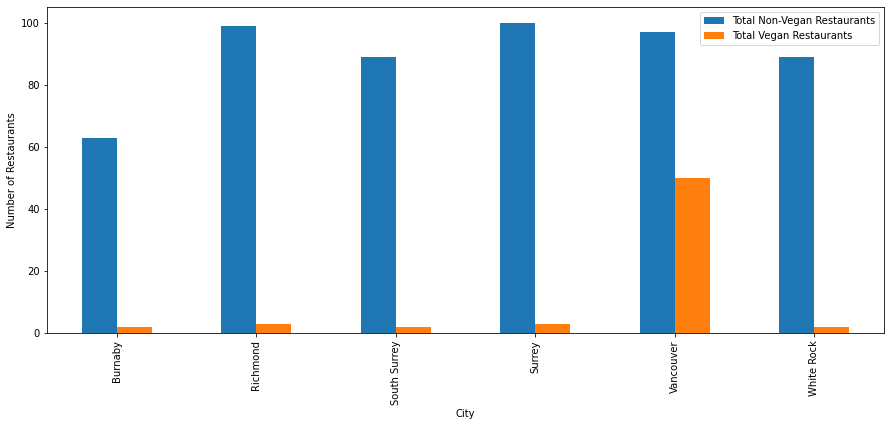

,Total Non-Vegan Restaurants,Total Vegan Restaurants
City,,
Burnaby,63,2
Richmond,99,3
South Surrey,89,2
Surrey,100,3
Vancouver,97,50
White Rock,89,2


In [260]:
BC_venues_all = BC_venues_df.merge(BC_venues_vegan_df, on='City')

BC_venues_all.plot(kind='bar', figsize=(15, 6))
plt.xlabel('City')
plt.ylabel('Number of Restaurants')
plt.show()
BC_venues_all

## Analysis <a name="analysis"></a>

To analyze the data we will use Clustering (K-Means) to understand in which cities the Vegan restaurants are more. It will show how restaurants are spread across these cities. Plot for Non-vegan restaurants and plot for Vegan restaurants. This will show us and give an understanding in which area Vegan restaurants are less and in which of these areas there are more.


In [261]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BC_merged_vegan['Venue Latitude'], BC_merged_vegan['Venue Longitude'], BC_merged_vegan['City'], BC_merged_vegan['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results <a name = 'results'></a>

Our analysis shows that although there is a great number of restaurants in Vancouver area, there are lot of opportunities in the suburban cities in Greater vancouver area. Highest concentration of restaurants was detected in Vancouver city. With almost 30% of the restaurants found are Vegan, so we focused our attention to areas Burnaby, Langley, Surrey, White Rock and South Surrey. Even though these areas do not offer tourists spots, there is a increasing demand for vegan food in the residential areas. Vegan food offers variety of options for the people with alergies and people who want few healthy options.

Here we reviewed the comparison between the Vegan restaurants to Non-Vegan restaurants and a bar graph has been plotted which shows the number of the restaurants in each of the city. It shows how many of them are Non-Vegan and compared to that how many of them are Vegan ones. 

## Conclusion <a name='conclusion'></a>

Purpose of this project was to identify cities in the Greater Vancouver area where Vegan restaurants are low in number, in order to aid stakeholders in narrowing down the search for optimal location. Clustering of cities was then performed in order to create maps and find the cities where there are low to no restaurants. Using the map we can identify that other than Vancouver downtown and Vancouver city all other city centers have potential to have more vegan restaurants. 

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations. We can certainly expand more on this and build a model, taking into consideration additional factors like attractiveness of each location, proximity to major locations like malls, real estate availability, prices, social and economic background of every neighborhood in every city.